In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import os
import math
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn import metrics
import time
import pickle
import metric_learn
from sklearn.decomposition import PCA  
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import LocalOutlierFactor
import functools
import tempfile
import datetime
import tensorflow as tf
import mlflow
from mlflow.models import infer_signature
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.python.client import device_lib; print(device_lib.list_local_devices())
import tensorflow as tf
tf.config.list_physical_devices('GPU')
from utils import make_data, make_data_rev, make_label, calc_leq, leq_filter, validate, figure, figure_detail, plot_timeseries, fig_pr, auc_gs, fig_th_f

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7803508943568387740
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7798259712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5747887565447835873
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7664311028801395136
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7798259712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8911218691069412506
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [2]:
data_dir='filtered_csv_label'
original = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df=df[df['day']<=9]
df

original  label  time  day
0            53.4      0    15    0
1            52.8      0    15    0
2            52.8      0    15    0
3            53.2      0    15    0
4            53.6      0    15    0
...           ...    ...   ...  ...
3995345      45.9      0     5    9
3995346      45.6      0     5    9
3995347      45.8      0     5    9
3995348      45.7      0     5    9
3995349      45.9      0     5    9

[3995350 rows x 4 columns]

# ホールドアウト検証
## 訓練、テストへ分割
* テスト（最終評価用）：6, 7, 8, 9 日目
---
ラベル付け
* 全体：0, 1, 2, 3, 4, 5 日目
* 訓練ローテ：(訓練、ラベル付与対象)=([0, 1, 2, 3, 4], 5)・・・([5, 0, 1, 2, 3], 4)

In [3]:
best_params={'window': 5, 'nk': 12}

In [4]:
test_day=[6, 7, 8, 9]
semi_train_day=[0, 1, 2, 3, 4, 5]

test_df=df[(df['day'].isin(test_day))].reset_index(drop=True)
semi_train_df=df[(df['day'].isin(semi_train_day))].reset_index(drop=True)

In [5]:
df_list=[]

window=best_params['window']
for i in set(df['day']):
    lag=[] 
    lag.append(make_data(semi_train_df.loc[semi_train_df['day']==i, ['original']], 'original', window))
    lag.append(semi_train_df.loc[semi_train_df['day']==i, ['day']])
    lag.append(semi_train_df.loc[semi_train_df['day']==i, ['label']])
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
semi_train_df=pd.concat(df_list)
semi_train_df=semi_train_df.dropna().reset_index(drop=True)
semi_train_df.loc[:, 'pred']=0

In [6]:
semi_train_df

original  original_lag1  original_lag2  original_lag3  original_lag4  \
0            53.6           53.2           52.8           52.8           53.4   
1            54.0           53.6           53.2           52.8           52.8   
2            54.7           54.0           53.6           53.2           52.8   
3            55.7           54.7           54.0           53.6           53.2   
4            55.5           55.7           54.7           54.0           53.6   
...           ...            ...            ...            ...            ...   
2393381      45.0           45.4           45.1           44.8           45.4   
2393382      45.2           45.0           45.4           45.1           44.8   
2393383      45.1           45.2           45.0           45.4           45.1   
2393384      45.1           45.1           45.2           45.0           45.4   
2393385      46.0           45.1           45.1           45.2           45.0   

         day  label  pred  
0          0      0     0  
1          0      0     0  
2          0      0     0  
3          0      0     0  
4          0      0     0  
...      ...    ...   ...  
2393381    5      0     0  
2393382    5      0     0  
2393383    5      0     0  
2393384    5      0     0  
2393385    5      0     0  

[2393386 rows x 8 columns]

## K近傍法で疑似ラベル（異常度）付与

In [7]:
labeling_day_num=1
cv_comb=np.array(semi_train_day).reshape((-1, labeling_day_num)).tolist()
cv_comb

[[0], [1], [2], [3], [4], [5]]

In [8]:
for i in cv_comb:
    label_train_day=[k for k in semi_train_day if k not in i]
    label_grant_day=i
    print(f'訓練データ：{label_train_day}')
    print(f'ラベル付与データ：{label_grant_day}日目')

    semi_train_x=semi_train_df[(semi_train_df['day'].isin(label_train_day))][semi_train_df.columns[:-3]].reset_index(drop=True)
    labeling_x=semi_train_df[(semi_train_df['day'].isin(label_grant_day))][semi_train_df.columns[:-3]].reset_index(drop=True)

    nk = best_params['nk']
    neigh = NearestNeighbors(n_neighbors=nk)
    neigh.fit(semi_train_x)
    d = neigh.kneighbors(labeling_x)[0]
    d = np.mean(d, axis=1)
    
    semi_train_df.loc[semi_train_df['day'].isin(label_grant_day), 'pred']=d
semi_train_df_tmp=semi_train_df[['original', 'day', 'pred', 'label']]
semi_train_df_tmp.to_csv('semi_train_data/semi_train_df_pred.csv')

訓練データ：[1, 2, 3, 4, 5]
ラベル付与データ：[0]日目
訓練データ：[0, 2, 3, 4, 5]
ラベル付与データ：[1]日目
訓練データ：[0, 1, 3, 4, 5]
ラベル付与データ：[2]日目
訓練データ：[0, 1, 2, 4, 5]
ラベル付与データ：[3]日目
訓練データ：[0, 1, 2, 3, 5]
ラベル付与データ：[4]日目
訓練データ：[0, 1, 2, 3, 4]
ラベル付与データ：[5]日目


## 重みcolumn調整

In [6]:
test_day=[6, 7, 8, 9]
semi_train_day=[0, 1, 2, 3, 4, 5]
labeling_day_num=1
cv_comb=np.array(semi_train_day).reshape((-1, labeling_day_num)).tolist()


data_dir='semi_train_data'
semi_train_df= pd.read_csv( os.path.join(data_dir, 'semi_train_df_pred.csv'), index_col=0 )
semi_train_df

original  day      pred  label
0            53.6    0  0.199618      0
1            54.0    0  0.151213      0
2            54.7    0  0.164040      0
3            55.7    0  0.181788      0
4            55.5    0  0.236920      0
...           ...  ...       ...    ...
2393381      45.0    5  0.117259      0
2393382      45.2    5  0.091667      0
2393383      45.1    5  0.050000      0
2393384      45.1    5  0.000000      0
2393385      46.0    5  0.157313      0

[2393386 rows x 4 columns]

In [7]:
for i in cv_comb:
    label_train_day=[k for k in semi_train_day if k not in i]
    label_grant_day=i
    print(f'訓練データ：{label_train_day}')
    print(f'ラベル付与データ：{label_grant_day}日目')
    d = semi_train_df.loc[semi_train_df['day'].isin(label_grant_day), 'pred'].values
    
    #閾値設定
    #kmeans
    n_clusters=2
    #init default=’k-means++’
    model = KMeans(n_clusters=n_clusters, n_init=10)  
    model.fit(d.reshape((-1, 1)))
    clusters = model.predict(d.reshape((-1, 1)))  
    result=pd.DataFrame({'d':d, 'cluster':clusters})
    thr_list=[]
    for j in range(n_clusters):
        thr_list.append(result.loc[result['cluster']==j, 'd'].max())
    thr_min=sorted(thr_list)[-2]
    thr_max=sorted(thr_list)[-1]
    thr_range=result.loc[(result['d']>thr_min)&(result['d']<=thr_max), ['d']]
    Q1 = float(thr_range.quantile(0.25).iloc[0])
    Q3 = float(thr_range.quantile(0.75).iloc[0])
    IQR = Q3 - Q1
    thr = min(float(Q3 + 1.5 * IQR), thr_max)
    print(thr)
    
    semi_train_df.loc[semi_train_df['day'].isin(label_grant_day), 'weight']\
    = np.where(d>=thr, 1, 0)
    print('------------------------------------------------------')
semi_train_df_tmp=semi_train_df[['original', 'day', 'weight', 'label']]
semi_train_df_tmp.to_csv('semi_train_data/semi_train_df_weight.csv')

訓練データ：[1, 2, 3, 4, 5]
ラベル付与データ：[0]日目
2.0723558216580322
------------------------------------------------------
訓練データ：[0, 2, 3, 4, 5]
ラベル付与データ：[1]日目
2.3971378843801485
------------------------------------------------------
訓練データ：[0, 1, 3, 4, 5]
ラベル付与データ：[2]日目
1.7010568137154647
------------------------------------------------------
訓練データ：[0, 1, 2, 4, 5]
ラベル付与データ：[3]日目
2.4377808397180005
------------------------------------------------------
訓練データ：[0, 1, 2, 3, 5]
ラベル付与データ：[4]日目
2.451733944938331
------------------------------------------------------
訓練データ：[0, 1, 2, 3, 4]
ラベル付与データ：[5]日目
2.0188096650707785
------------------------------------------------------


## オートエンコーダ

In [8]:
data_dir='semi_train_data'
semi_train_df= pd.read_csv( os.path.join(data_dir, 'semi_train_df_weight.csv'), index_col=0 )
semi_train_df

original  day  weight  label
0            53.6    0     0.0      0
1            54.0    0     0.0      0
2            54.7    0     0.0      0
3            55.7    0     0.0      0
4            55.5    0     0.0      0
...           ...  ...     ...    ...
2393381      45.0    5     0.0      0
2393382      45.2    5     0.0      0
2393383      45.1    5     0.0      0
2393384      45.1    5     0.0      0
2393385      46.0    5     0.0      0

[2393386 rows x 4 columns]

In [11]:
df_list=[]

window=15
for i in set(semi_train_df['day']):
    lag=[] 
    lag.append(make_data(semi_train_df.loc[semi_train_df['day']==i, ['original']], 'original', window))
    lag.append(semi_train_df.loc[semi_train_df['day']==i, ['weight']])
    lag.append(semi_train_df.loc[semi_train_df['day']==i, ['day']])
    lag.append(semi_train_df.loc[semi_train_df['day']==i, ['label']])
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
semi_train_df=pd.concat(df_list)
semi_train_df=semi_train_df.dropna().reset_index(drop=True)
semi_train_df.loc[:, 'aed']=0
semi_train_df.loc[:, 'aed_label']=0

In [12]:
semi_train_df

original  original_lag1  original_lag2  original_lag3  original_lag4  \
0            55.0           55.0           54.9           54.9           54.9   
1            55.2           55.0           55.0           54.9           54.9   
2            54.7           55.2           55.0           55.0           54.9   
3            54.4           54.7           55.2           55.0           55.0   
4            54.5           54.4           54.7           55.2           55.0   
...           ...            ...            ...            ...            ...   
2393297      45.0           45.4           45.1           44.8           45.4   
2393298      45.2           45.0           45.4           45.1           44.8   
2393299      45.1           45.2           45.0           45.4           45.1   
2393300      45.1           45.1           45.2           45.0           45.4   
2393301      46.0           45.1           45.1           45.2           45.0   

         original_lag5  original_lag6  original_lag7  original_lag8  \
0                 55.0           55.7           55.8           55.6   
1                 54.9           55.0           55.7           55.8   
2                 54.9           54.9           55.0           55.7   
3                 54.9           54.9           54.9           55.0   
4                 55.0           54.9           54.9           54.9   
...                ...            ...            ...            ...   
2393297           45.6           45.0           45.7           45.1   
2393298           45.4           45.6           45.0           45.7   
2393299           44.8           45.4           45.6           45.0   
2393300           45.1           44.8           45.4           45.6   
2393301           45.4           45.1           44.8           45.4   

         original_lag9  original_lag10  original_lag11  original_lag12  \
0                 55.7            55.5            55.7            54.7   
1                 55.6            55.7            55.5            55.7   
2                 55.8            55.6            55.7            55.5   
3                 55.7            55.8            55.6            55.7   
4                 55.0            55.7            55.8            55.6   
...                ...             ...             ...             ...   
2393297           44.9            44.9            45.2            44.6   
2393298           45.1            44.9            44.9            45.2   
2393299           45.7            45.1            44.9            44.9   
2393300           45.0            45.7            45.1            44.9   
2393301           45.6            45.0            45.7            45.1   

         original_lag13  original_lag14  weight  day  label  aed  aed_label  
0                  54.0            53.6     0.0    0      0    0          0  
1                  54.7            54.0     0.0    0      0    0          0  
2                  55.7            54.7     0.0    0      0    0          0  
3                  55.5            55.7     0.0    0      0    0          0  
4                  55.7            55.5     0.0    0      0    0          0  
...                 ...             ...     ...  ...    ...  ...        ...  
2393297            45.0            45.2     0.0    5      0    0          0  
2393298            44.6            45.0     0.0    5      0    0          0  
2393299            45.2            44.6     0.0    5      0    0          0  
2393300            44.9            45.2     0.0    5      0    0          0  
2393301            44.9            44.9     0.0    5      0    0          0  

[2393302 rows x 20 columns]

In [14]:
input_size=10
intermediate_dim=7
latent_dim=4

class AnomalyDetector(Model):
    def __init__(self):
        super().__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(input_size, activation="relu", input_shape=(window,)),
            layers.Dense(intermediate_dim, activation="relu"),
            layers.Dense(latent_dim, activation="relu")])
        self.decoder = tf.keras.Sequential([
            layers.Dense(intermediate_dim, activation="relu", input_shape=(latent_dim,)),
            layers.Dense(input_size, activation="relu"),
            layers.Dense(window, activation="sigmoid")])

    def call(self, x):
        encoded = self.encoder(x[:, :-1])
        decoded = self.decoder(encoded)
        return decoded
    
# カスタム損失
def custom_loss(y_true, y_pred):
    mae=tf.math.reduce_mean(tf.abs(y_true[:, :-1] - y_pred))

    return mae


訓練データ：[0, 1, 3, 4, 5]
ラベル付与データ：[2]日目
Epoch 1/5
7648/7648 [==============================] - 28s 3ms/step - loss: 0.0127 - val_loss: 0.0067
Epoch 2/5
7648/7648 [==============================] - 27s 4ms/step - loss: 0.0062 - val_loss: 0.0067
Epoch 3/5
7648/7648 [==============================] - 28s 4ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 4/5
7648/7648 [==============================] - 27s 4ms/step - loss: 0.0053 - val_loss: 0.0055
Epoch 5/5
7648/7648 [==============================] - 28s 4ms/step - loss: 0.0052 - val_loss: 0.0055


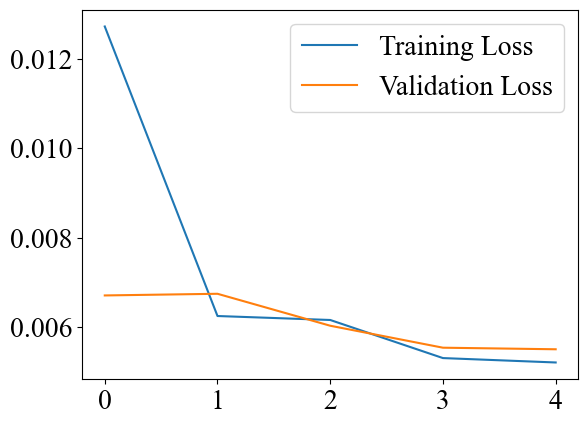

13499/13499 [==============================] - 15s 1ms/step
------------------------------------------------------


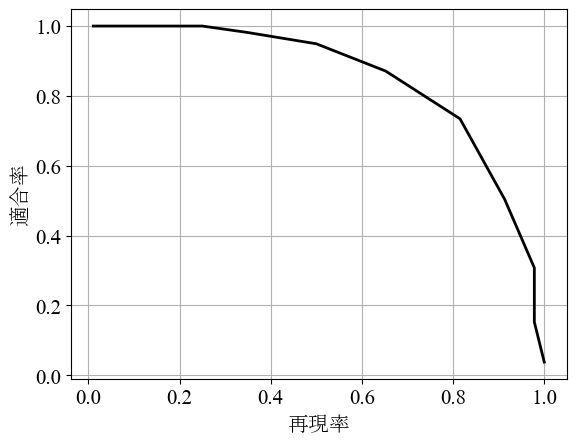

AUC：0.8415333224364131
理想の閾値：0.16
F値（最高）：0.7726984353917775
適合率（F値が最高の時）：0.7343949044585987
再現率（F値が最高の時）：0.8152173913043478


In [15]:
# テストデータとする日
i=[2]
label_train_day=[k for k in semi_train_day if k not in i]
label_grant_day=i
print(f'訓練データ：{label_train_day}')
print(f'ラベル付与データ：{label_grant_day}日目')
# Log the hyperparameters

semi_train_x=semi_train_df[(semi_train_df['day'].isin(label_train_day))&(semi_train_df['weight']==0)][semi_train_df.columns[:-4]].reset_index(drop=True)
labeling_x=semi_train_df[(semi_train_df['day'].isin(label_grant_day))][semi_train_df.columns[:-4]].reset_index(drop=True)

train_weight=semi_train_x[['weight']].values
semi_train_x.drop(columns='weight', inplace=True)
labeling_weight=labeling_x[['weight']].values
labeling_x.drop(columns='weight', inplace=True)

# tf.reduce_min関数を使用して、train_dataテンソル内の最小値を計算しています。
# min_valにはtrain_data内の最小値が代入されます。
min_val = tf.reduce_min(semi_train_x)
# tf.reduce_max関数を使用して、train_dataテンソル内の最大値を計算しています。
# max_valにはtrain_data内の最大値が代入されます。
max_val = tf.reduce_max(semi_train_x)
train_data = (semi_train_x.values - min_val) / (max_val - min_val)
labeling_data = (labeling_x.values - min_val) / (max_val - min_val)

train_data =np.hstack([train_data , train_weight])
labeling_data =np.hstack([labeling_data , labeling_weight])


# データの型をtf.float32に変換
train_data = tf.cast(train_data, tf.float32)

labeling_data = tf.cast(labeling_data, tf.float32)
autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss=custom_loss)

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    restore_best_weights=True
)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = autoencoder.fit(train_data, train_data, 
      epochs=5, 
      batch_size=256,
      validation_data=(labeling_data, labeling_data),
      callbacks=[callback],
      shuffle=True)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

reconstructions = autoencoder.predict(labeling_data)
#     異常度算出
d= tf.keras.losses.mae(reconstructions, labeling_data[:, :-1]).numpy()
semi_train_df.loc[semi_train_df['day'].isin(label_grant_day), 'aed']=d
print('------------------------------------------------------')

test_v=semi_train_df.loc[semi_train_df['day'].isin(label_grant_day), ['original', 'label']].copy().reset_index(drop=True)
d_test=(d-d.min())/(d.max()-d.min())

thr_bins=20
p_score, r_score, f_score, thresholds, thr, auc = fig_pr(test_v, d_test, thr_bins)
f_max=f_score.max()
p_max=p_score[np.argmax(f_score)]
r_max=r_score[np.argmax(f_score)]
print('\033[31m'+f'AUC：{auc}'+'\033[0m')
print(f'理想の閾値：{thr}')
print(f'F値（最高）：{f_max}')
print(f'適合率（F値が最高の時）：{p_max}')
print(f'再現率（F値が最高の時）：{r_max}')
plot_timeseries([test_v['original'].values], test_v['label'].values, d=d_test, thr=thr)